### 1. 生成训练用数据集

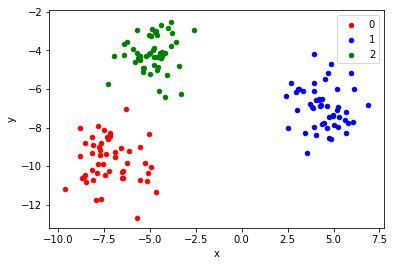

In [1]:
import pandas as pd
from matplotlib import pyplot
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

# generate 2d classification dataset
X, y = make_blobs(n_samples=150, centers=3, n_features=2)
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

### 2. LVQ

In [2]:
import numpy as np
from collections import Counter

class LVQ(object):
    def __init__(self, learning_rate, max_iter):
        """ 初始化
        
        arguments:
        ----------
        learning_rate: float (0,1)
        """
        self._learning_rate = learning_rate
        self._max_iter = max_iter
        self._labels = None
        self._centers = None
        
    def _init(self, X, labels, class_labels):
        """ 初始化
        """
        _centers = []
        _labels = []
        
        # 随机选择类中心
        labels_cnt = Counter(class_labels)
        for key, value in labels_cnt.items():
            _labels.extend([str(key)+"_"+str(i) for i in range(value)])
            inx, = np.where(labels==key)
            inx = np.random.choice(inx, value, replace=False)
            _centers.extend(X[inx])
            
        self._labels = np.array(_labels)
        self._centers = np.array(_centers)
        
    def fit(self, X, y, class_labels):
        """ 训练 lvq
        
        arguments:
        ----------
        X: list or narray, shape=(n_sample, n_features)
        y: labels, list or narray, shape=(n_sample, )
        class_labels: given the cluster label
        """
        X = np.array(X)
        y = np.array(y)
        class_labels = np.array(class_labels)
        
        # 初始化
        self._init(X, y, class_labels)
        
        # 遍历
        for i in range(self._max_iter):
            # 随机抽取一个样本
            inx = np.random.choice(y, 1, replace=False)
            x = X[inx]
            yt = y[inx][0]
            
            # 计算到每个聚类中心的欧式距离
            euclidean_distance = np.sqrt(np.sum((x - self._centers) * (x - self._centers), axis=1))
            # 寻找最小距离的那个类别
            min_labels_inx = np.argmin(euclidean_distance, axis=0)
            min_labels = self._labels[min_labels_inx].split("_")[0]
            # 更新该类别的聚类中心位置
            min_labels_center = self._centers[min_labels_inx]
            if str(min_labels) == str(yt):
                self._centers[min_labels_inx] = min_labels_center + self._learning_rate * (x - min_labels_center)
            else:
                self._centers[min_labels_inx] = min_labels_center - self._learning_rate * (x - min_labels_center)
                
    def predict(self, X):
        """ 预测
        """
        pre_y = []
        for x in X:
            euclidean_distance = np.sqrt(np.sum((x - self._centers) * (x - self._centers), axis=1))
            min_labels_inx = np.argmin(euclidean_distance, axis=0)
            pre_y.append(min_labels_inx)
            # min_labels = self._labels[min_labels_inx]
        return np.array(pre_y)

In [12]:
lvq = LVQ(learning_rate=0.5, max_iter=100)
lvq.fit(X, y, class_labels=[0,1,2,0,1,2])

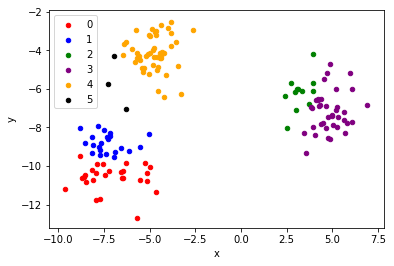

In [16]:
yy = lvq.predict(X)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=yy))
colors = {0:'red', 1:'blue', 2:"green", 3:"purple", 4:"orange", 5:"black"}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()